Package yang dibutuhkan

In [14]:
from datetime import date, datetime
from multiprocessing.spawn import import_main_path
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np


Ambil data dari yahoo finance

In [15]:
tickers = ["ANTM.JK","ASII.JK"]

today = date.today()
# print(today)
start_date = '2010-01-01'
end_date = today

panel_data = data.DataReader(tickers, 'yahoo',start_date, end_date)


In [16]:

close = panel_data["Close"]

all_weekdays = pd.date_range(start = start_date,    end= end_date, freq='B')

close = close.reindex(all_weekdays)

close = close.dropna()

#print(all_weekdays)

In [4]:
close.isnull().sum()

Symbols
ANTM.JK    0
ASII.JK    0
dtype: int64

In [5]:
close.describe()

Symbols,ANTM.JK,ASII.JK
count,3000.000000,3000.000000
mean,1147.926380,6694.035000
std,576.049980,1212.741553
min,287.000000,3280.000000
25%,753.750000,5850.000000
50%,942.873993,6900.000000
75%,1503.558594,7600.000000
max,3190.000000,9150.000000


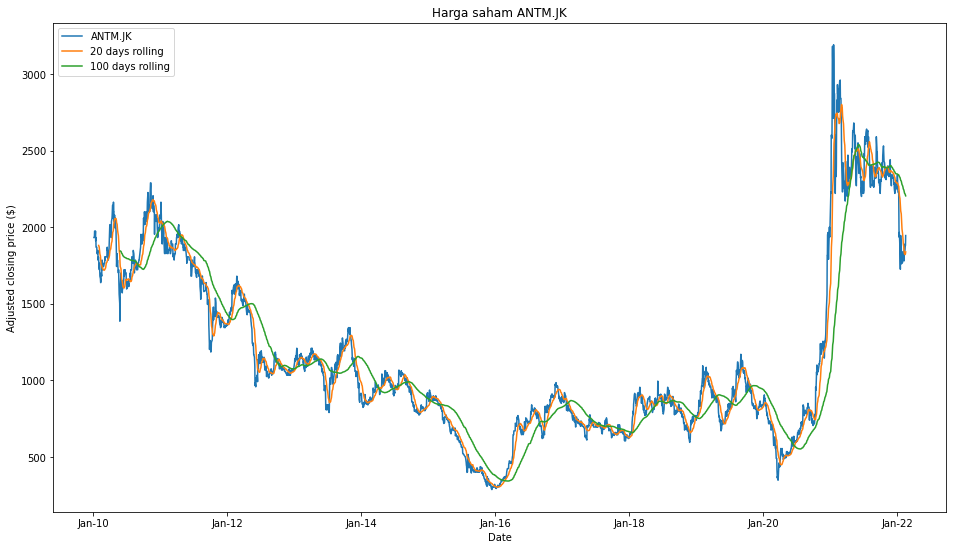

In [17]:
# Get the saham timeseries. This now returns a Pandas Series object indexed by date.
lb_saham = 'ANTM.JK'
saham = close.loc[:, lb_saham]


# Calculate the 20 and 100 days moving averages of the closing prices
short_rolling_saham = saham.rolling(window=20).mean()
long_rolling_saham = saham.rolling(window=100).mean()

# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(saham.index, saham, label=lb_saham)
ax.plot(short_rolling_saham.index, short_rolling_saham, label='20 days rolling')
ax.plot(long_rolling_saham.index, long_rolling_saham, label='100 days rolling')

# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham {}'.format(lb_saham))
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted closing price ($)')
ax.legend()

TRAIN TEST SPLIT

In [18]:
train_saham, test_saham = train_test_split(saham.values, test_size=0.2, shuffle=False)

RESCALE DATA

In [19]:
scaler = MinMaxScaler()
train_scale = scaler.fit_transform(train_saham.reshape(-1, 1))
test_scale = scaler.fit_transform(test_saham.reshape(-1, 1))

In [20]:
split=int((1-0.2)*len(saham))
all_date = saham.index
date_train = saham.index[:split]
date_test = saham.index[split:]

In [54]:
look_back = 40 
train_gen = TimeseriesGenerator(train_scale, train_scale, length=look_back, batch_size=1)     
test_gen = TimeseriesGenerator(test_scale, test_scale, length=look_back, batch_size=1)

In [94]:
len(train_gen)

2380

In [57]:
len(test_gen)

580

MODELING

In [55]:
model_forecast = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, activation='relu', return_sequences=True, input_shape=(look_back, 1)),
  tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
  tf.keras.layers.LSTM(64, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(1)
])

model_forecast.summary()



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 40, 64)            16896     
                                                                 
 lstm_22 (LSTM)              (None, 40, 64)            33024     
                                                                 
 lstm_23 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________


In [57]:
from time import time

start = time()

optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model_forecast.compile(loss='mse', optimizer='adam')
model_forecast.fit(train_gen, epochs=5, verbose=1)


print("total time: ", time()-start, 'seconds')

Epoch 1/5
2368/2368 [==============================] - 79s 32ms/step - loss: 0.0022
Epoch 2/5
2368/2368 [==============================] - 80s 34ms/step - loss: 0.0023
Epoch 3/5
2368/2368 [==============================] - 92s 39ms/step - loss: 0.0020
Epoch 4/5
2368/2368 [==============================] - 80s 34ms/step - loss: 0.0019
Epoch 5/5
2368/2368 [==============================] - 78s 33ms/step - loss: 0.0018
total time:  409.10060119628906 seconds


In [58]:
pred_train = scaler.inverse_transform(model_forecast.predict(train_gen))
pred = scaler.inverse_transform(model_forecast.predict(test_gen))

MATRIKS EVALUASI MODEL Test

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt

mse = round(mean_squared_error(saham.values[split+look_back:],pred), 2)
mae = round(mean_absolute_error(saham.values[split+look_back:],pred), 2)
rmse = round(sqrt(mean_squared_error(saham.values[split+look_back:],pred)),2)
mape = round(mean_absolute_percentage_error(saham.values[split+look_back:],pred),2)
r2 = round(r2_score(saham.values[split+look_back:],pred),2)


# print("MSE score is " + str(mse) + "MAE score is " + str(mae) + "RMSE score is "+ str(rmse) + "MAPE score is "+ str(mape) + "R2 Score is" + str(r2))

scale10 = round((saham.max() - saham.min()) * (10 / 100), 2)

if mae < scale10:
  print("MAE "+str(mae))
else:
  print("MAE " + str(mae) )
  
if mse < scale10:
  print('MSE: ')
else:
  print('MSE: '+str(mse) )

if rmse < scale10:
  print('RMSE: '+str(rmse))
else:
  print('RMSE: '+str(rmse))

print('MAPE: '+ str(mape))

print('R2_score: ' + str(r2))

MAE 81.13
MSE: 11980.62
RMSE: 109.46
MAPE: 0.05
R2_score: 0.98


MATRIKS EVALUASI MODEL TRAIn

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt

mse = round(mean_squared_error(saham.values[:split-look_back],pred_train), 2)
mae = round(mean_absolute_error(saham.values[:split-look_back],pred_train), 2)
rmse = round(sqrt(mean_squared_error(saham.values[:split-look_back],pred_train)),2)
mape = round(mean_absolute_percentage_error(saham.values[:split-look_back],pred_train),2)
r2 = round(r2_score(saham.values[:split-look_back],pred_train),2)


# print("MSE score is " + str(mse) + "MAE score is " + str(mae) + "RMSE score is "+ str(rmse) + "MAPE score is "+ str(mape) + "R2 Score is" + str(r2))

scale10 = round((saham.max() - saham.min()) * (10 / 100), 2)

if mae < scale10:
  print("MAE "+str(mae))
else:
  print("MAE " + str(mae) )
  
if mse < scale10:
  print('MSE: ')
else:
  print('MSE: '+str(mse) )

if rmse < scale10:
  print('RMSE: '+str(rmse))
else:
  print('RMSE: '+str(rmse))

print('MAPE: '+ str(mape))

print('R2_score: ' + str(r2))

MAE 334.15
MSE: 144181.15
RMSE: 379.71
MAPE: 0.33
R2_score: 0.28


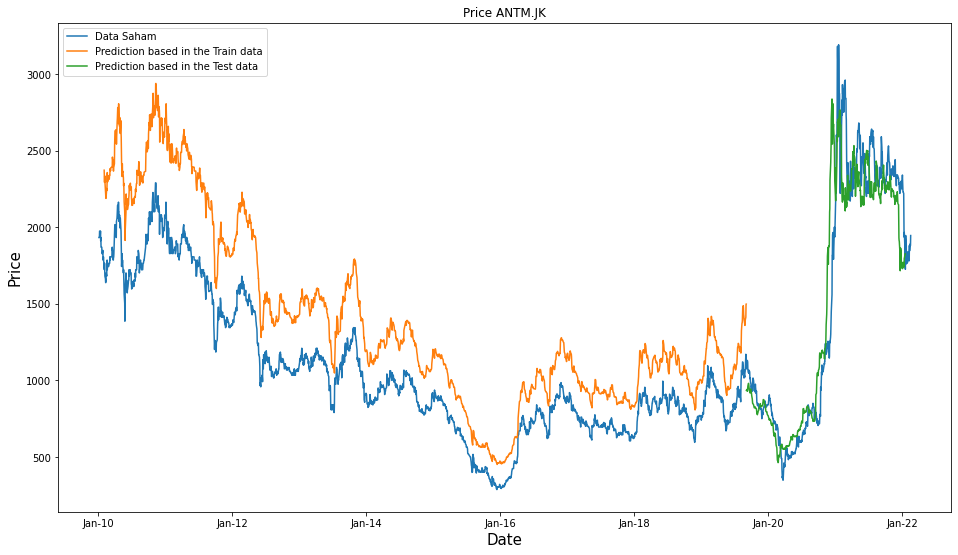

In [37]:
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(all_date, saham, label = "Data Saham")
ax.plot(date_train[look_back:], pred_train, label = "Prediction based in the Train data")
ax.plot(date_test[:-look_back], pred, label = "Prediction based in the Test data")
ax.set_title('Price {}'.format(lb_saham))

# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_xlabel('Date',fontsize=15)
ax.set_ylabel('Price',fontsize=15)
ax.legend()
# plt.savefig("bbni_10_pred")
plt.show()

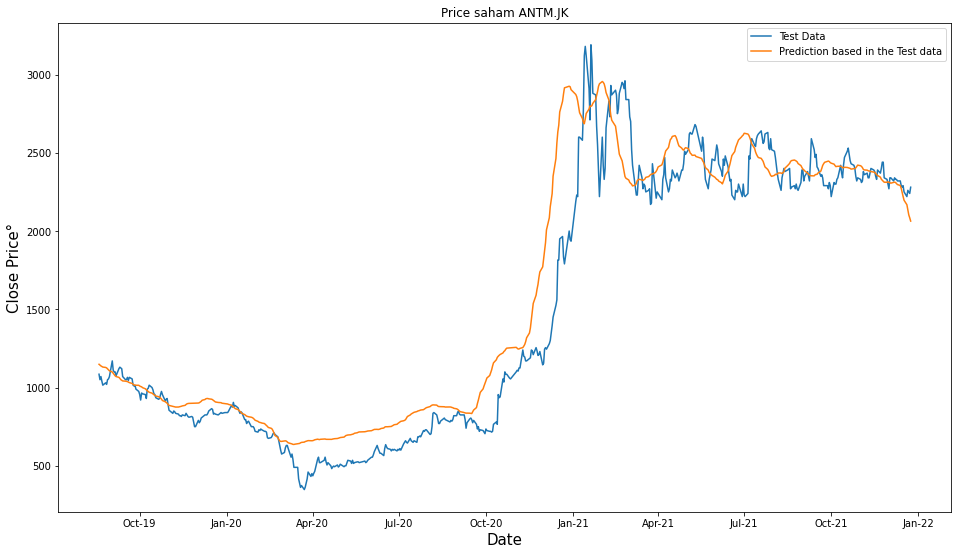

In [49]:
fig, ax = plt.subplots(figsize=(16,9))
#perbandingan data asli dan prediksi
ax.plot(date_test[:-look_back], test_saham.reshape(-1)[:-look_back], label = "Test Data")
ax.plot(date_test[:-look_back], pred, label = "Prediction based in the Test data")

# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Price saham {}'.format(lb_saham))
ax.set_xlabel('Date',fontsize=15)
ax.set_ylabel('Close Price°',fontsize=15)


ax.legend()
# ax.savefig("bbni_10_sidetoside")
plt.show()